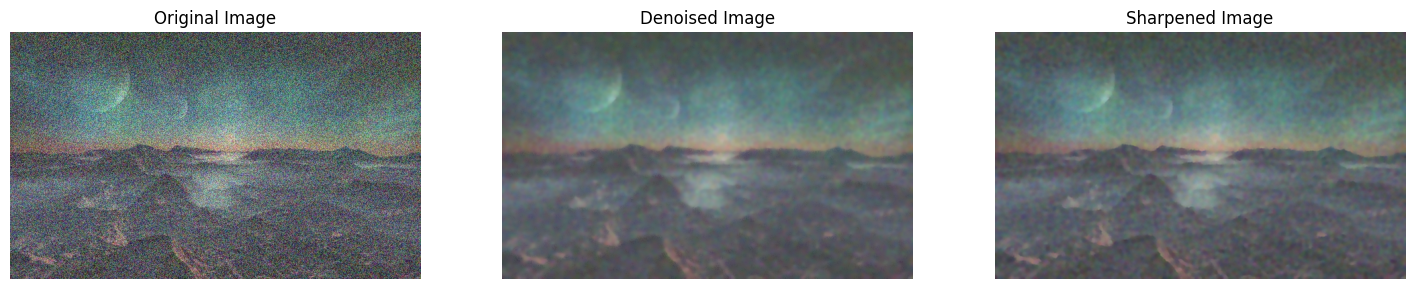

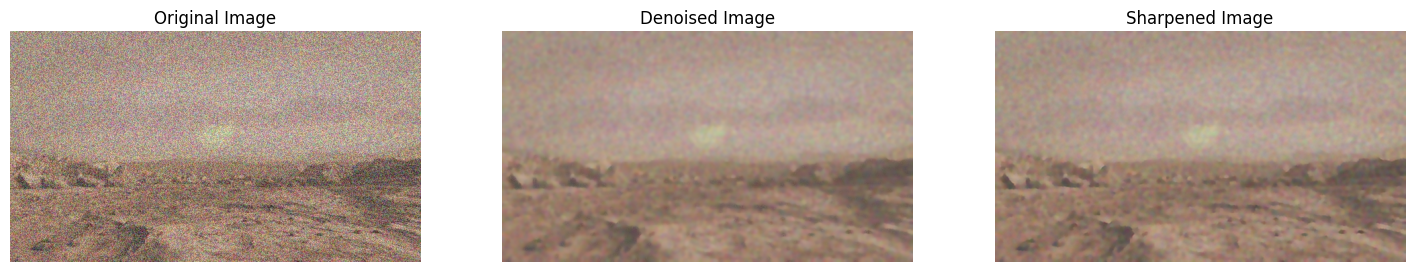

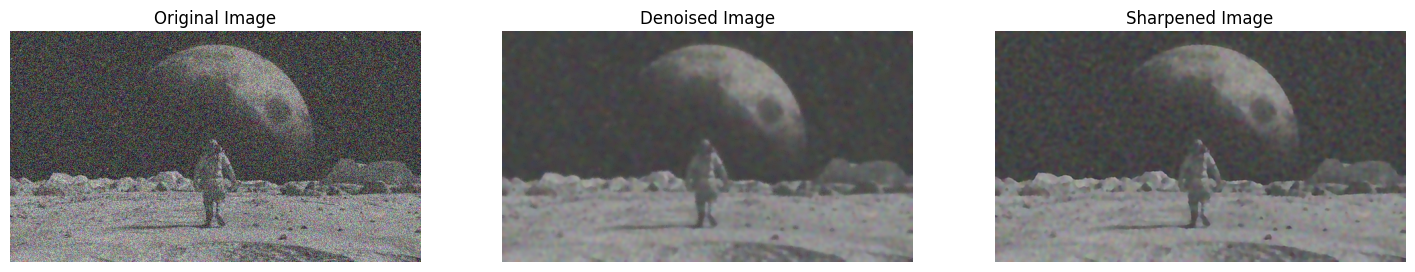

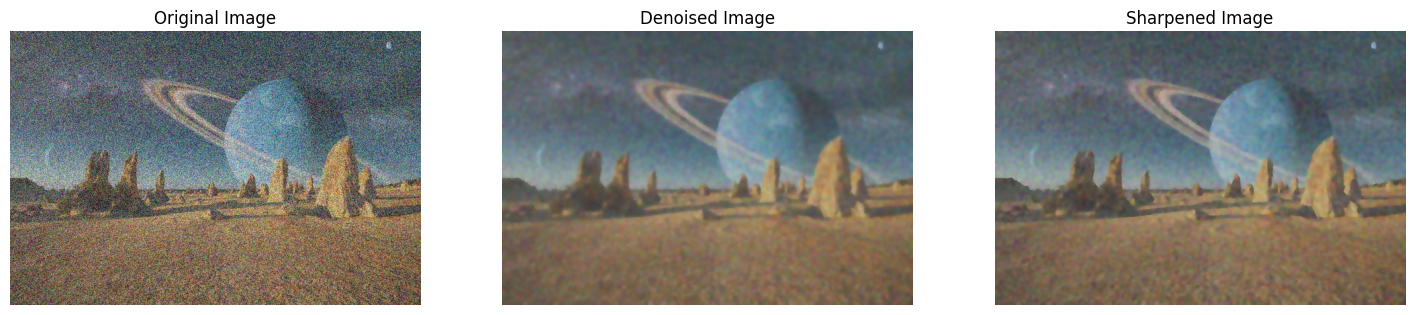

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

directory_path = 'images'

# Function to apply unsharp masking
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.5, threshold=0):
    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)

    # Calculate the sharpened image
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)

    # Apply the threshold
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)

    return sharpened

# Function to process and restore an image
def restore_image(image_path):
    # Load the image
    original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert to grayscale for inpainting mask creation
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Create a mask for inpainting
    _, mask = cv2.threshold(gray_image, 80, 255, cv2.THRESH_BINARY_INV)

    # Apply noise reduction using Gaussian Blur
    gaussian_blur_image = cv2.GaussianBlur(original_image, (5, 5), 0)

    # Apply noise reduction using Bilateral Filtering
    bilateral_filter_image = cv2.bilateralFilter(gaussian_blur_image, d=9, sigmaColor=75, sigmaSpace=75)

    # Restore missing or distorted portions using inpainting
    restored_image = cv2.inpaint(bilateral_filter_image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    sharpened_image = unsharp_mask(bilateral_filter_image)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    bilateral_filter_image_rgb = cv2.cvtColor(restored_image, cv2.COLOR_BGR2RGB)
    sharpened_image_rgb = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB)

    # Display the original, blurred, and restored images side by side
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_image_rgb)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Denoised Image')
    plt.imshow(bilateral_filter_image_rgb)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Sharpened Image')
    plt.imshow(sharpened_image_rgb)
    plt.axis('off')

    plt.show()

# Process each image in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(directory_path, filename)
        restore_image(image_path)
